# Titanic: Feature Engineering

### Import thư viện

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid", font_scale=1.1)

exps_dir = "../../data"
data_path = "../exps/data"

### Đọc dữ liệu 

In [ ]:
# Đọc dữ liệu gốc
df_train = pd.read_csv(f"{exps_dir}/train.csv")
df_test = pd.read_csv(f"{exps_dir}/test.csv")

# Đọc dữ liệu đã preprocessing
df_train_pre = pd.read_excel(f"{data_path}/train.xlsx")
df_valid_pre  = pd.read_excel(f"{data_path}/valid.xlsx")
df_test_pre  = pd.read_excel(f"{data_path}/test.xlsx")

# Đọc dữ liệu index 
idx = np.load(f'{data_path}/idx.npz')
id_train = idx['id_train']
id_valid = idx['id_valid']

print("Kích thước dữ liệu:")
print("Train:", df_train.shape)
print("Test:", df_test.shape)

df_train.head()

Kích thước dữ liệu:
Train: (891, 12)
Test: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Xử lý giá trị thiếu

In [34]:
# Kiểm tra giá trị thiếu train
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [35]:
# Kiểm tra giá trị thiếu test
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [36]:
# Điền thiếu cho train
# Age → median
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].median())

# Fare → median
df_train["Fare"] = df_train["Fare"].fillna(df_train["Fare"].median())

# Embarked → mode
df_train["Embarked"] = df_train["Embarked"].fillna(df_train["Embarked"].mode()[0])

# Cabin → 'U' (Unknown)
df_train["Cabin"] = df_train["Cabin"].fillna("U")

In [37]:
# Điền thiếu cho test
# Age → median (của test)
df_test["Age"] = df_test["Age"].fillna(df_test["Age"].median())

# Fare → median
df_test["Fare"] = df_test["Fare"].fillna(df_test["Fare"].median())

# Embarked → mode
if "Embarked" in df_test.columns:
    df_test["Embarked"] = df_test["Embarked"].fillna(df_test["Embarked"].mode()[0])

# Cabin → 'U'
if "Cabin" in df_test.columns:
    df_test["Cabin"] = df_test["Cabin"].fillna("U")

In [39]:
print("Train missing after fill:")
print(df_train.isnull().sum())

print("\nTest missing after fill:")
print(df_test.isnull().sum())

Train missing after fill:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Test missing after fill:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


### Đặc trưng Cabin

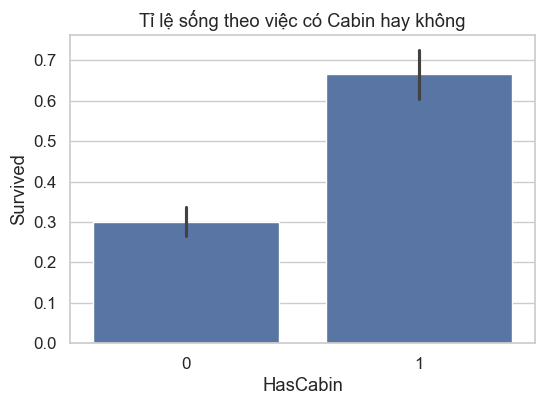

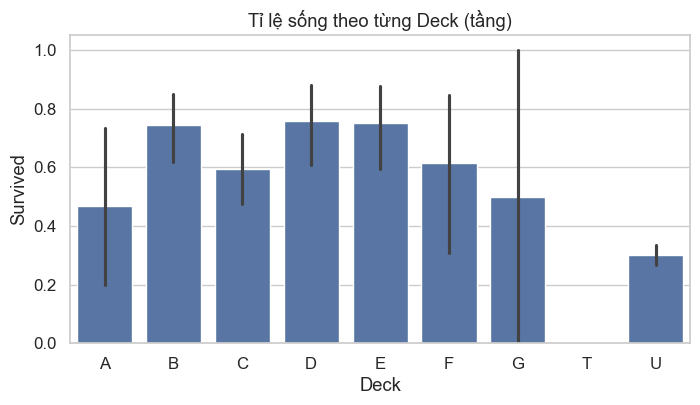

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Đặc trưng Cabin
df_train["HasCabin"] = df_train["Cabin"].apply(lambda x: 0 if x == "U" else 1)
df_test["HasCabin"] = df_test["Cabin"].apply(lambda x: 0 if x == "U" else 1)

df_train["Deck"] = df_train["Cabin"].apply(lambda x: x[0] if x != "U" else "U")
df_test["Deck"] = df_test["Cabin"].apply(lambda x: x[0] if x != "U" else "U")

# Vẽ biểu đồ tỉ lệ sống theo HasCabin
plt.figure(figsize=(6,4))
sns.barplot(x="HasCabin", y="Survived", data=df_train)
plt.title("Tỉ lệ sống theo việc có Cabin hay không")
plt.show()

# Biểu đồ tỉ lệ sống theo Deck
plt.figure(figsize=(8,4))
sns.barplot(x="Deck", y="Survived", data=df_train, order=sorted(df_train["Deck"].unique()))
plt.title("Tỉ lệ sống theo từng Deck (tầng)")
plt.show()

**Nhận xét**
- Hành khách có Cabin riêng thường thuộc tầng lớp cao → tỉ lệ sống cao hơn rõ rệt.

- Một số Deck như B, C, D có tỉ lệ sống cao hơn do gần thuyền cứu sinh.

### Trích danh xưng từ Name (Title)

Danh xưng sau khi chuẩn hóa:
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


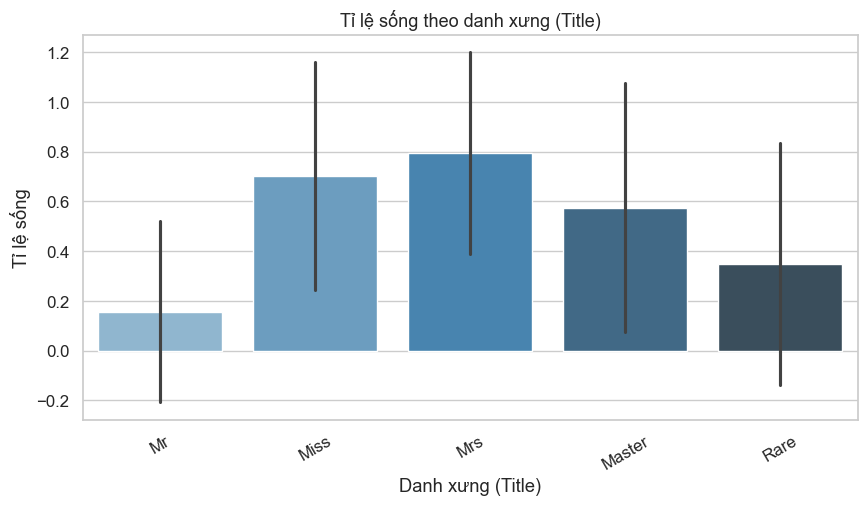

In [6]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Hàm tách danh xưng từ Name
def extract_title(name):
    match = re.search(r",\s*([A-Za-z\s]+)\.", name)
    return match.group(1).strip() if match else "Unknown"

# Áp dụng cho cả train và test
df_train["Title"] = df_train["Name"].apply(extract_title)
df_test["Title"] = df_test["Name"].apply(extract_title)

# Gom nhóm danh xưng hiếm vào "Rare"
rare_titles = [
    "Lady", "Countess", "the Countess", "Capt", "Col", "Don", "Dr",
    "Major", "Rev", "Sir", "Jonkheer", "Dona"
]

for df in [df_train, df_test]:
    df["Title"] = df["Title"].replace(rare_titles, "Rare")
    df["Title"] = df["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})

# Kiểm tra lại danh xưng
print("Danh xưng sau khi chuẩn hóa:")
print(df_train["Title"].value_counts())

# Biểu đồ tỉ lệ sống theo danh xưng
plt.figure(figsize=(10, 5))
sns.barplot(
    x="Title",
    y="Survived",
    data=df_train,
    order=df_train["Title"].value_counts().index,
    errorbar="sd",
    palette="Blues_d"
)
plt.title("Tỉ lệ sống theo danh xưng (Title)", fontsize=13)
plt.xlabel("Danh xưng (Title)")
plt.ylabel("Tỉ lệ sống")
plt.xticks(rotation=30)
plt.show()

**Nhận xét**
- Các danh xưng ‘Mrs’, ‘Miss’ có tỷ lệ sống cao, phản ánh quy tắc ưu tiên phụ nữ và trẻ em.

- ‘Master’ (thường là trẻ em nam) cũng có tỷ lệ sống khá tốt.

- ‘Mr’ có tỷ lệ sống thấp nhất, đa số là nam trưởng thành.

- Các danh xưng hiếm (“Rare”) thường thuộc tầng lớp sĩ quan hoặc quý tộc nam → tỷ lệ sống thấp hơn.

### Đặc trưng Family

<Figure size 800x500 with 0 Axes>

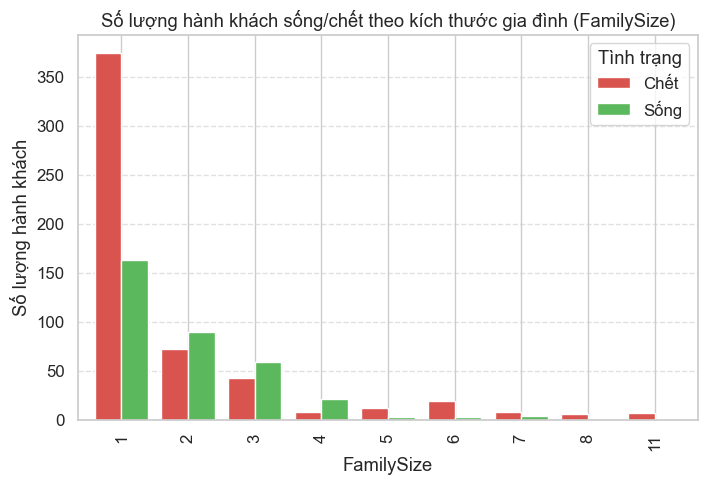

In [50]:
for df in [df_train, df_test]:
    # FamilySize = Số người đi cùng (anh chị em, cha mẹ) + bản thân
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    
    # IsAlone = đi một mình
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

plt.figure(figsize=(8,5))

family_counts = df_train.groupby(["FamilySize", "Survived"]).size().unstack(fill_value=0)

# Vẽ biểu đồ 2 cột
family_counts.plot(
    kind="bar",
    figsize=(8,5),
    color=["#d9534f", "#5cb85c"],
    width=0.8
)

plt.title("Số lượng hành khách sống/chết theo kích thước gia đình (FamilySize)")
plt.xlabel("FamilySize")
plt.ylabel("Số lượng hành khách")
plt.legend(["Chết", "Sống"], title="Tình trạng")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

**Nhận xét**
- FamilySize = 1 (đi một mình) có tỉ lệ sống rất thấp.

- FamilySize từ 2–4 có tỉ lệ sống cao nhất, vì thường đi cùng người thân → được hỗ trợ khi gặp nạn.

- FamilySize lớn hơn 4 có tỉ lệ sống giảm, do khó di chuyển và dễ bị tách đoàn trong lúc di tản.

### Đặc trưng nhóm tuổi (AgeBin)

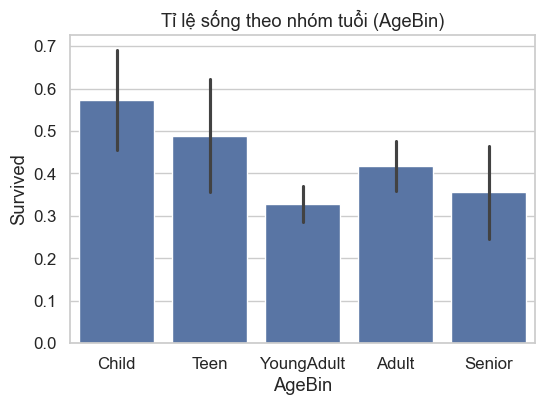

In [51]:
bins = [0, 12, 18, 30, 50, 80]
labels = ["Child", "Teen", "YoungAdult", "Adult", "Senior"]

for df in [df_train, df_test]:
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=False)

plt.figure(figsize=(6,4))
sns.barplot(x="AgeBin", y="Survived", data=df_train, order=labels)
plt.title("Tỉ lệ sống theo nhóm tuổi (AgeBin)")
plt.show()

**Nhận xét**
- Trẻ em (Child) có tỉ lệ sống sót cao nhất, cho thấy việc ưu tiên trẻ em trong cứu hộ.
- Người lớn trong độ tuổi từ 30-50 ("Adult") có tỉ lệ sống thấp nhất.

### Nhóm giá vé (FareBin)

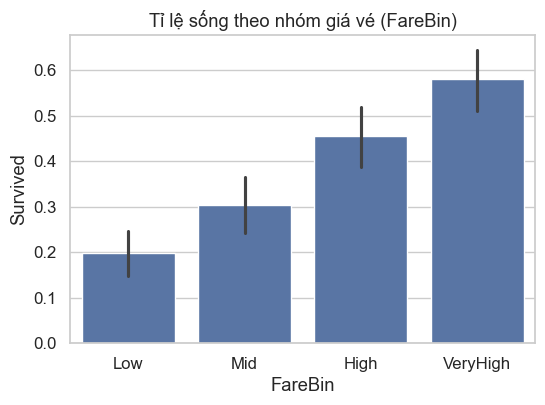

In [52]:
df_train["FareBin"] = pd.qcut(df_train["Fare"], 4, labels=["Low", "Mid", "High", "VeryHigh"])
df_test["FareBin"] = pd.qcut(df_test["Fare"], 4, labels=["Low", "Mid", "High", "VeryHigh"])

plt.figure(figsize=(6,4))
sns.barplot(x="FareBin", y="Survived", data=df_train, order=["Low", "Mid", "High", "VeryHigh"])
plt.title("Tỉ lệ sống theo nhóm giá vé (FareBin)")
plt.show()

**Nhận xét**
- Giá vé càng cao thì tỉ lệ sống sót càng cao, phản ánh rõ mối liên hệ với hạng vé (Pclass).

In [ ]:
# Lưu dữ liệu sau khi feature engineering để train mô hình
import os

save_dir = "../exps/data"
os.makedirs(save_dir, exist_ok=True)

# Lưu lại dữ liệu train & test sau khi thêm đặc trưng mới
df_train.to_excel(f"{save_dir}/train_feat.xlsx", index=False)
df_test.to_excel(f"{save_dir}/test_feat.xlsx", index=False)

print("Đã lưu dữ liệu sau khi Feature Engineering:")
print(f"- {save_dir}/train_feat.xlsx")
print(f"- {save_dir}/test_feat.xlsx")

Đã lưu dữ liệu sau khi Feature Engineering:
- ../exps/data/train_feat.xlsx
- ../exps/data/test_feat.xlsx
